<a href="https://colab.research.google.com/github/mipypf/practical-mi-guide/blob/develop/chapter4/src/image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 画像セグメンテーションのタスクを実行

### 使用するデータセットの参考文献
 - https://publikationen.bibliothek.kit.edu/1000129520
 - https://github.com/2Obe/BSData
 - https://www.sciencedirect.com/science/article/pii/S2352340921009185?via%3Dihub

## Google colabを使用の場合、ランタイムのタブから「ランタイムのタイプを変更」→ハードウェアアクセラレータと進み、T4 GPUを選択

In [1]:
# 以下のコマンドでGPUが使用可能かを確認
! nvidia-smi

Tue Jan 21 08:40:32 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## データセットのダウンロード
- https://publikationen.bibliothek.kit.edu/1000129520 のDownloadボタンをクリックし、遷移先から規約を確認してデータセット10.35097-1278.tarをダウンロード

## Google Colabの準備

In [2]:
# Google Colabを利用する場合はTrue、そうでない場合はFalseとする
colab = True

In [3]:
# Google Colabのファイルをクリックし、10.35097-1278.tarをドラッグ＆ドロップしてアップロード
# 10.35097-1278.tarを以下のコマンドで解凍する
!tar -xvf 10.35097-1278.tar

10.35097-1278/
10.35097-1278/data/
10.35097-1278/data/readme.txt
10.35097-1278/data/descriptive-md/
10.35097-1278/data/descriptive-md/dataset.desc_md.xml
10.35097-1278/data/technical-md/
10.35097-1278/data/technical-md/dataset.tech_md.xml
10.35097-1278/data/dataset/
10.35097-1278/data/dataset/BSData-main.zip
10.35097-1278/bagit.txt
10.35097-1278/manifest-md5.txt
10.35097-1278/bag-info.txt
10.35097-1278/tagmanifest-md5.txt


In [4]:
if colab:
  INPUT_FILE_PATH = "./"
  OUTPUT_FILE_PATH = "./"
else:
  INPUT_FILE_PATH = "../input/"
  OUTPUT_FILE_PATH = "../output/"

In [5]:
import zipfile

# BSData-main.zipファイルを解凍する
with zipfile.ZipFile(INPUT_FILE_PATH + "10.35097-1278/data/dataset/BSData-main.zip", "r") as zip_ref:
    zip_ref.extractall(INPUT_FILE_PATH)

## ライブラリをインポート

In [6]:
! pip install labelme==5.5.0
! pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.2/276.2 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.4 MB/s eta 0:00:00
  Created wheel for labelme: filename=labelme-5.5.0-py3-none-any.whl size=1437463 sha256=50f79948c531cb7b1464e71ac4cb770d2e9c0afab75d339fef00d5650c1a68ce
  Stored in directory: /root/.cache/pip/wheels/d2/65/c7/ed0feabb950f9b5dbe0e97e854f603dc25ae0d7edf1

In [7]:
import base64
import gc
import glob
import io
import json
import os
import pathlib
import pickle
import random
import sys
import warnings

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from albumentations.pytorch import ToTensorV2
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import (
    CosineAnnealingLR,
    CosineAnnealingWarmRestarts,
    LambdaLR,
    OneCycleLR,
    ReduceLROnPlateau,
    StepLR,
)
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from tqdm.notebook import tqdm

tqdm.pandas()

import cv2
import imageio
import labelme
import segmentation_models_pytorch as smp
import sklearn.exceptions
from labelme import utils
from PIL import Image, ImageDraw
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split

warnings.filterwarnings("ignore")

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [8]:
# pytorchのverを確認
print(torch.__version__)

2.5.1+cu121


## random seed、デバイスの設定

In [9]:
# seedの固定
def seed_everything(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything()

# デバイスの設定
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


## 画像の読み込みと表示

In [10]:
# 画像のパスを取得
train_path = (
    INPUT_FILE_PATH + "BSData-main/data"
)
train_files = sorted(glob.glob(os.path.join(train_path, "*.jpg")))
print(f"Train data: {len(train_files)}")

Train data: 1104


In [11]:
# アノテーションのパスを取得
train_label_path = (
    INPUT_FILE_PATH + "BSData-main/label"
)
train_labels = sorted(glob.glob(os.path.join(train_label_path, "*.json")))
print(f"Train label: {len(train_labels)}")

Train label: 394


In [12]:
# train_filesのうち.jpgを除いた部分がtrain_labelsのうち.jsonを除いた部分と一致するもののみを取得
train_files = [
    f
    for f in train_files
    if os.path.splitext(os.path.basename(f))[0]
    in [os.path.splitext(os.path.basename(l))[0] for l in train_labels]
]
print(f"Train data: {len(train_files)}")

Train data: 394


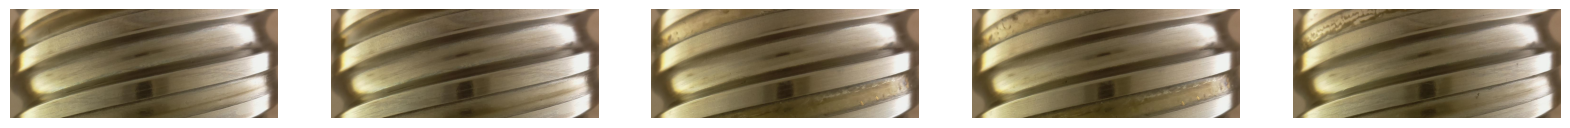

In [13]:
# train_filesの画像を表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = cv2.imread(train_files[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
plt.show()

## ラベルデータからマスクデータを作成

In [14]:
train_labels[0]

'./BSData-main/label/01_200902053521_585000_090_crop_2.json'

In [15]:
train_mask_path = OUTPUT_FILE_PATH + "image_segmentation"

In [16]:
!labelme_export_json {train_labels[0]} --out {train_mask_path}

2025-01-21 08:41:20,285 [INFO   ] export_json:main:66- Saved to: ./image_segmentation


In [17]:
# ループ内で各ファイルに固有の出力フォルダを指定
for label in train_labels:
    # JSONファイル名から固有のフォルダ名を作成
    label_name = os.path.splitext(os.path.basename(label))[0]
    output_folder = os.path.join(train_mask_path, label_name)

    # 出力フォルダが存在しない場合は作成
    os.makedirs(output_folder, exist_ok=True)

    # Labelmeコマンドを実行
    !labelme_export_json {label} --out {output_folder}

2025-01-21 08:41:22,527 [INFO   ] export_json:main:66- Saved to: ./image_segmentation/01_200902053521_585000_090_crop_2
2025-01-21 08:41:24,515 [INFO   ] export_json:main:66- Saved to: ./image_segmentation/01_200902093536_585000_090_crop_2
2025-01-21 08:41:26,711 [INFO   ] export_json:main:66- Saved to: ./image_segmentation/01_200905041126_277500_315_crop_2
2025-01-21 08:41:28,744 [INFO   ] export_json:main:66- Saved to: ./image_segmentation/01_200905081130_277500_315_crop_2
2025-01-21 08:41:32,751 [INFO   ] export_json:main:66- Saved to: ./image_segmentation/01_200905081805_560000_000_crop_2
2025-01-21 08:41:34,687 [INFO   ] export_json:main:66- Saved to: ./image_segmentation/01_200905121127_277500_315_crop_2
2025-01-21 08:41:36,948 [INFO   ] export_json:main:66- Saved to: ./image_segmentation/01_200905121802_560000_000_crop_2
2025-01-21 08:41:38,882 [INFO   ] export_json:main:66- Saved to: ./image_segmentation/01_200905161132_277500_315_crop_2
2025-01-21 08:41:39,988 [INFO   ] export

## 画像、マスクデータをリストに格納

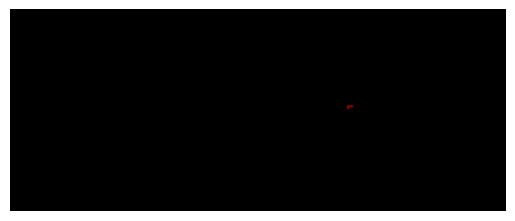

In [18]:
# 上記で出力した各フォルダのlabel.pngをPIL.Image.Imageのままmask_list = []に格納
mask_list = []
for label in train_labels:
    label_name = os.path.splitext(os.path.basename(label))[0]
    output_folder = os.path.join(train_mask_path, label_name)

    mask = Image.open(os.path.join(output_folder, "label.png"))
    mask_list.append(mask)

# mask_listの画像を1つ表示
plt.imshow(mask_list[0])
plt.axis("off")
plt.show()

In [19]:
img_paths = []

for label in train_labels:
    img_path = os.path.join(
        train_path, os.path.splitext(os.path.basename(label))[0] + ".jpg"
    )
    img_paths.append(img_path)

## 画像セグメンテーションモデルの構築に向けた各種設定

In [20]:
# データセットクラスを作成
class SegmentationDataset(Dataset):
    def __init__(self, img_paths, mask_list, transform=None):
        self.img_paths = img_paths
        self.mask_list = mask_list
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")
        mask = self.mask_list[idx]

        img = np.array(img)
        mask = np.array(mask)

        if self.transform:
            transformed = self.transform(image=img, mask=mask)
            img = transformed["image"]
            mask = transformed["mask"]

        return img, mask


# データセットを学習用とテスト用に分割（今回はデータの20%を検証データ、それ以外を学習データとしてSingle holdでの検証としている）
train_img_paths, val_img_paths, train_mask_list, val_mask_list = train_test_split(
    img_paths, mask_list, test_size=0.2, random_state=42
)

# データ拡張の設定
transform = A.Compose(
    [
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.Normalize(),
        ToTensorV2(),
    ] # 学習データにはデータ拡張を行う
)

valid_transform = A.Compose([A.Resize(256, 256), A.Normalize(), ToTensorV2()]
                            )  # 検証データにはデータ拡張を行わず、リサイズと正規化のみを行う。

# データセットを作成
train_dataset = SegmentationDataset(
    train_img_paths, train_mask_list, transform=transform
)
val_dataset = SegmentationDataset(val_img_paths, val_mask_list, transform=valid_transform)

# データセットをDataLoaderに変換
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True
                          ) # shuffle=Trueに設定すると、エポックごとに訓練データがランダムにシャッフルされる。これにより、モデルが訓練データを学習する順序が毎回異なり、過学習を防ぐ効果がある。
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False
                        ) # shuffle=Falseに設定すると、データがシャッフルされない。検証データはシャッフルする必要がないため、Falseに設定する。


# モデルを定義
model = smp.Unet("resnet18", encoder_weights="imagenet", in_channels=3, classes=1).to(
    device
)

# 損失関数を定義
criterion = nn.BCEWithLogitsLoss()

# 最適化手法を定義
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 320MB/s]


## 画像、マスクデータの確認

In [21]:
len(train_dataset)

315

In [22]:
len(val_dataset)

79

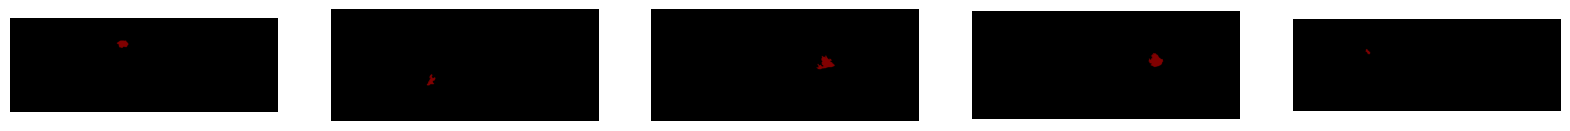

In [23]:
# train_mask_listのマスクを5枚表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    mask = train_mask_list[i]
    plt.imshow(mask)
    plt.axis("off")
plt.show()

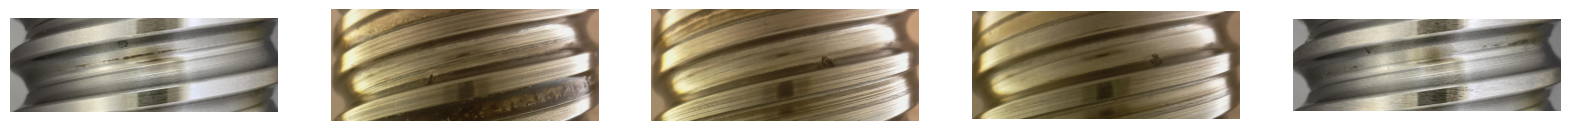

In [24]:
# train_img_pathsの画像を5枚表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = Image.open(train_img_paths[i]).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
plt.show()

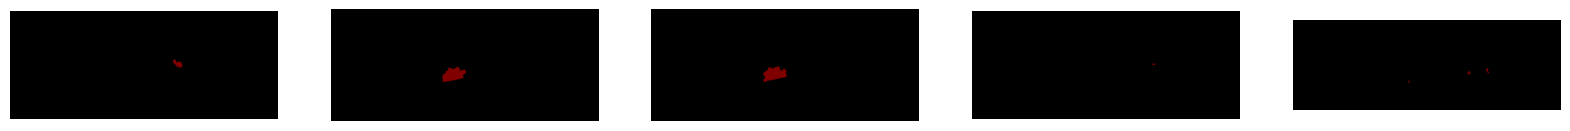

In [25]:
# val_mask_listのマスクを5枚表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    mask = val_mask_list[i]
    plt.imshow(mask)
    plt.axis("off")
plt.show()

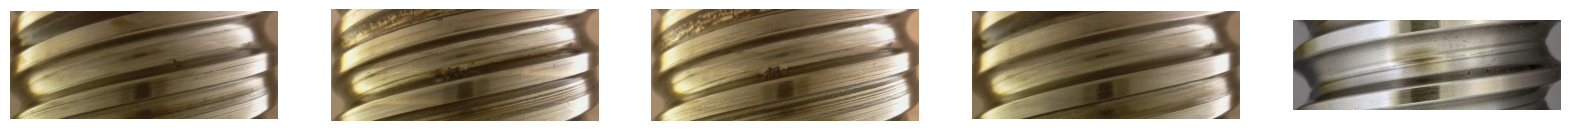

In [26]:
# val_img_pathsの画像を5枚表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = Image.open(val_img_paths[i]).convert("RGB")
    plt.imshow(img)
    plt.axis("off")
plt.show()

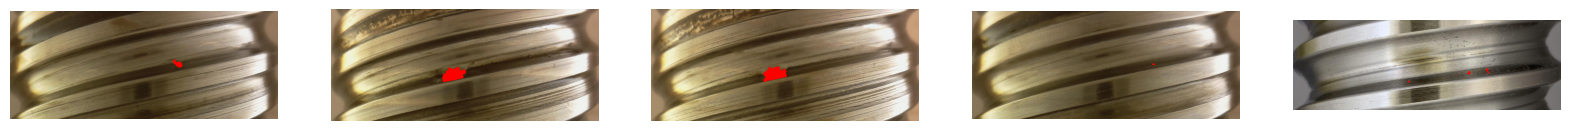

In [27]:
# val_img_paths, val_mask_listの画像とマスクを重ねて5枚表示
plt.figure(figsize=(20, 10))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = Image.open(val_img_paths[i]).convert("RGB")
    mask = val_mask_list[i]
    img = np.array(img)
    mask = np.array(mask)
    img[mask == 1] = [255, 0, 0]
    plt.imshow(img)
    plt.axis("off")
plt.show()

## 画像セグメンテーションモデルの構築

In [28]:
# ベストモデル保存のための初期化
best_valid_loss = float("inf")

# ベストモデル保存のためのパスを定義
save_path = OUTPUT_FILE_PATH + "image_segmentation_best_model.pth"

# 損失を記録するリスト
train_losses = []
valid_losses = []

# エポックス数を定義
num_epochs = 100

# スケーラーを定義
scaler = GradScaler()

# スケジューラーを定義
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

# 学習の実行
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch in tqdm(train_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(x)
            y = y.unsqueeze(1).type(torch.float32)
            loss = criterion(outputs, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

    # 検証ループ
    model.eval()
    val_epoch_loss = 0.0
    for batch in tqdm(val_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            outputs = model(x)
            y = y.unsqueeze(1).type(torch.float32)
            loss = criterion(outputs, y)

        val_epoch_loss += loss.item()

    valid_loss = val_epoch_loss / len(val_loader)
    valid_losses.append(valid_loss)
    print(f"Epoch: {epoch+1}/{num_epochs}, Val Loss: {valid_loss:.4f}")

    # 改善された場合にモデルを保存
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
        print(f"Model saved at epoch {epoch+1} with validation loss {valid_loss:.4f}")

    scheduler.step(valid_loss)

print(f"Best validation loss: {best_valid_loss:.4f}, Model saved to {save_path}")

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1/100, Train Loss: 0.7506


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/100, Val Loss: 0.5974
Model saved at epoch 1 with validation loss 0.5974


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 2/100, Train Loss: 0.5504


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 2/100, Val Loss: 0.4891
Model saved at epoch 2 with validation loss 0.4891


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 3/100, Train Loss: 0.4070


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 3/100, Val Loss: 0.3160
Model saved at epoch 3 with validation loss 0.3160


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 4/100, Train Loss: 0.3106


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4/100, Val Loss: 0.2700
Model saved at epoch 4 with validation loss 0.2700


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 5/100, Train Loss: 0.2545


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5/100, Val Loss: 0.2282
Model saved at epoch 5 with validation loss 0.2282


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 6/100, Train Loss: 0.2164


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 6/100, Val Loss: 0.2060
Model saved at epoch 6 with validation loss 0.2060


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 7/100, Train Loss: 0.1897


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 7/100, Val Loss: 0.1784
Model saved at epoch 7 with validation loss 0.1784


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 8/100, Train Loss: 0.1683


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 8/100, Val Loss: 0.1576
Model saved at epoch 8 with validation loss 0.1576


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 9/100, Train Loss: 0.1481


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 9/100, Val Loss: 0.1412
Model saved at epoch 9 with validation loss 0.1412


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 10/100, Train Loss: 0.1314


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10/100, Val Loss: 0.1239
Model saved at epoch 10 with validation loss 0.1239


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 11/100, Train Loss: 0.1181


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 11/100, Val Loss: 0.1112
Model saved at epoch 11 with validation loss 0.1112


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 12/100, Train Loss: 0.1067


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 12/100, Val Loss: 0.0995
Model saved at epoch 12 with validation loss 0.0995


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 13/100, Train Loss: 0.0972


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 13/100, Val Loss: 0.0933
Model saved at epoch 13 with validation loss 0.0933


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 14/100, Train Loss: 0.0893


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 14/100, Val Loss: 0.0834
Model saved at epoch 14 with validation loss 0.0834


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 15/100, Train Loss: 0.0822


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 15/100, Val Loss: 0.0769
Model saved at epoch 15 with validation loss 0.0769


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 16/100, Train Loss: 0.0756


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 16/100, Val Loss: 0.0707
Model saved at epoch 16 with validation loss 0.0707


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 17/100, Train Loss: 0.0691


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 17/100, Val Loss: 0.0661
Model saved at epoch 17 with validation loss 0.0661


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 18/100, Train Loss: 0.0643


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 18/100, Val Loss: 0.0598
Model saved at epoch 18 with validation loss 0.0598


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 19/100, Train Loss: 0.0611


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 19/100, Val Loss: 0.0570
Model saved at epoch 19 with validation loss 0.0570


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 20/100, Train Loss: 0.0559


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 20/100, Val Loss: 0.0532
Model saved at epoch 20 with validation loss 0.0532


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 21/100, Train Loss: 0.0517


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 21/100, Val Loss: 0.0477
Model saved at epoch 21 with validation loss 0.0477


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 22/100, Train Loss: 0.0479


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 22/100, Val Loss: 0.0454
Model saved at epoch 22 with validation loss 0.0454


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 23/100, Train Loss: 0.0448


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 23/100, Val Loss: 0.0419
Model saved at epoch 23 with validation loss 0.0419


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 24/100, Train Loss: 0.0422


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 24/100, Val Loss: 0.0397
Model saved at epoch 24 with validation loss 0.0397


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 25/100, Train Loss: 0.0398


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 25/100, Val Loss: 0.0371
Model saved at epoch 25 with validation loss 0.0371


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 26/100, Train Loss: 0.0373


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 26/100, Val Loss: 0.0356
Model saved at epoch 26 with validation loss 0.0356


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 27/100, Train Loss: 0.0351


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 27/100, Val Loss: 0.0331
Model saved at epoch 27 with validation loss 0.0331


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 28/100, Train Loss: 0.0333


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 28/100, Val Loss: 0.0317
Model saved at epoch 28 with validation loss 0.0317


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 29/100, Train Loss: 0.0314


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 29/100, Val Loss: 0.0297
Model saved at epoch 29 with validation loss 0.0297


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 30/100, Train Loss: 0.0298


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 30/100, Val Loss: 0.0280
Model saved at epoch 30 with validation loss 0.0280


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 31/100, Train Loss: 0.0282


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 31/100, Val Loss: 0.0273
Model saved at epoch 31 with validation loss 0.0273


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 32/100, Train Loss: 0.0266


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 32/100, Val Loss: 0.0255
Model saved at epoch 32 with validation loss 0.0255


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 33/100, Train Loss: 0.0254


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 33/100, Val Loss: 0.0237
Model saved at epoch 33 with validation loss 0.0237


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 34/100, Train Loss: 0.0243


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 34/100, Val Loss: 0.0227
Model saved at epoch 34 with validation loss 0.0227


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 35/100, Train Loss: 0.0228


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 35/100, Val Loss: 0.0215
Model saved at epoch 35 with validation loss 0.0215


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 36/100, Train Loss: 0.0217


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 36/100, Val Loss: 0.0203
Model saved at epoch 36 with validation loss 0.0203


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 37/100, Train Loss: 0.0207


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 37/100, Val Loss: 0.0197
Model saved at epoch 37 with validation loss 0.0197


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 38/100, Train Loss: 0.0196


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 38/100, Val Loss: 0.0187
Model saved at epoch 38 with validation loss 0.0187


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 39/100, Train Loss: 0.0189


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 39/100, Val Loss: 0.0176
Model saved at epoch 39 with validation loss 0.0176


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 40/100, Train Loss: 0.0181


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 40/100, Val Loss: 0.0167
Model saved at epoch 40 with validation loss 0.0167


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 41/100, Train Loss: 0.0172


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 41/100, Val Loss: 0.0162
Model saved at epoch 41 with validation loss 0.0162


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 42/100, Train Loss: 0.0164


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 42/100, Val Loss: 0.0155
Model saved at epoch 42 with validation loss 0.0155


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 43/100, Train Loss: 0.0158


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 43/100, Val Loss: 0.0147
Model saved at epoch 43 with validation loss 0.0147


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 44/100, Train Loss: 0.0152


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 44/100, Val Loss: 0.0142
Model saved at epoch 44 with validation loss 0.0142


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 45/100, Train Loss: 0.0147


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 45/100, Val Loss: 0.0137
Model saved at epoch 45 with validation loss 0.0137


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 46/100, Train Loss: 0.0140


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 46/100, Val Loss: 0.0138


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 47/100, Train Loss: 0.0137


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 47/100, Val Loss: 0.0128
Model saved at epoch 47 with validation loss 0.0128


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 48/100, Train Loss: 0.0131


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 48/100, Val Loss: 0.0121
Model saved at epoch 48 with validation loss 0.0121


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 49/100, Train Loss: 0.0127


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 49/100, Val Loss: 0.0119
Model saved at epoch 49 with validation loss 0.0119


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 50/100, Train Loss: 0.0121


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 50/100, Val Loss: 0.0112
Model saved at epoch 50 with validation loss 0.0112


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 51/100, Train Loss: 0.0117


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 51/100, Val Loss: 0.0109
Model saved at epoch 51 with validation loss 0.0109


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 52/100, Train Loss: 0.0114


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 52/100, Val Loss: 0.0105
Model saved at epoch 52 with validation loss 0.0105


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 53/100, Train Loss: 0.0110


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 53/100, Val Loss: 0.0102
Model saved at epoch 53 with validation loss 0.0102


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 54/100, Train Loss: 0.0107


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 54/100, Val Loss: 0.0098
Model saved at epoch 54 with validation loss 0.0098


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 55/100, Train Loss: 0.0102


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 55/100, Val Loss: 0.0096
Model saved at epoch 55 with validation loss 0.0096


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 56/100, Train Loss: 0.0100


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 56/100, Val Loss: 0.0092
Model saved at epoch 56 with validation loss 0.0092


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 57/100, Train Loss: 0.0097


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 57/100, Val Loss: 0.0090
Model saved at epoch 57 with validation loss 0.0090


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 58/100, Train Loss: 0.0094


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 58/100, Val Loss: 0.0088
Model saved at epoch 58 with validation loss 0.0088


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 59/100, Train Loss: 0.0092


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 59/100, Val Loss: 0.0086
Model saved at epoch 59 with validation loss 0.0086


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 60/100, Train Loss: 0.0089


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 60/100, Val Loss: 0.0083
Model saved at epoch 60 with validation loss 0.0083


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 61/100, Train Loss: 0.0087


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 61/100, Val Loss: 0.0081
Model saved at epoch 61 with validation loss 0.0081


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 62/100, Train Loss: 0.0084


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 62/100, Val Loss: 0.0078
Model saved at epoch 62 with validation loss 0.0078


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 63/100, Train Loss: 0.0082


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 63/100, Val Loss: 0.0075
Model saved at epoch 63 with validation loss 0.0075


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 64/100, Train Loss: 0.0080


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 64/100, Val Loss: 0.0077


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 65/100, Train Loss: 0.0077


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 65/100, Val Loss: 0.0071
Model saved at epoch 65 with validation loss 0.0071


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 66/100, Train Loss: 0.0075


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 66/100, Val Loss: 0.0070
Model saved at epoch 66 with validation loss 0.0070


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 67/100, Train Loss: 0.0073


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 67/100, Val Loss: 0.0067
Model saved at epoch 67 with validation loss 0.0067


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 68/100, Train Loss: 0.0071


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 68/100, Val Loss: 0.0065
Model saved at epoch 68 with validation loss 0.0065


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 69/100, Train Loss: 0.0069


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 69/100, Val Loss: 0.0063
Model saved at epoch 69 with validation loss 0.0063


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 70/100, Train Loss: 0.0067


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 70/100, Val Loss: 0.0063


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 71/100, Train Loss: 0.0065


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 71/100, Val Loss: 0.0061
Model saved at epoch 71 with validation loss 0.0061


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 72/100, Train Loss: 0.0064


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 72/100, Val Loss: 0.0060
Model saved at epoch 72 with validation loss 0.0060


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 73/100, Train Loss: 0.0063


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 73/100, Val Loss: 0.0059
Model saved at epoch 73 with validation loss 0.0059


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 74/100, Train Loss: 0.0061


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 74/100, Val Loss: 0.0056
Model saved at epoch 74 with validation loss 0.0056


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 75/100, Train Loss: 0.0060


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 75/100, Val Loss: 0.0058


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 76/100, Train Loss: 0.0061


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 76/100, Val Loss: 0.0054
Model saved at epoch 76 with validation loss 0.0054


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 77/100, Train Loss: 0.0059


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 77/100, Val Loss: 0.0052
Model saved at epoch 77 with validation loss 0.0052


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 78/100, Train Loss: 0.0057


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 78/100, Val Loss: 0.0053


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 79/100, Train Loss: 0.0056


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 79/100, Val Loss: 0.0050
Model saved at epoch 79 with validation loss 0.0050


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 80/100, Train Loss: 0.0055


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 80/100, Val Loss: 0.0051


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 81/100, Train Loss: 0.0053


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 81/100, Val Loss: 0.0048
Model saved at epoch 81 with validation loss 0.0048


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 82/100, Train Loss: 0.0053


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 82/100, Val Loss: 0.0048
Model saved at epoch 82 with validation loss 0.0048


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 83/100, Train Loss: 0.0051


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 83/100, Val Loss: 0.0047
Model saved at epoch 83 with validation loss 0.0047


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 84/100, Train Loss: 0.0051


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 84/100, Val Loss: 0.0046
Model saved at epoch 84 with validation loss 0.0046


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 85/100, Train Loss: 0.0049


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 85/100, Val Loss: 0.0045
Model saved at epoch 85 with validation loss 0.0045


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 86/100, Train Loss: 0.0050


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 86/100, Val Loss: 0.0052


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 87/100, Train Loss: 0.0050


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 87/100, Val Loss: 0.0044
Model saved at epoch 87 with validation loss 0.0044


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 88/100, Train Loss: 0.0047


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 88/100, Val Loss: 0.0043
Model saved at epoch 88 with validation loss 0.0043


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 89/100, Train Loss: 0.0047


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 89/100, Val Loss: 0.0044


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 90/100, Train Loss: 0.0045


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 90/100, Val Loss: 0.0041
Model saved at epoch 90 with validation loss 0.0041


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 91/100, Train Loss: 0.0045


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 91/100, Val Loss: 0.0042


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 92/100, Train Loss: 0.0046


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 92/100, Val Loss: 0.0041
Model saved at epoch 92 with validation loss 0.0041


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 93/100, Train Loss: 0.0043


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 93/100, Val Loss: 0.0040
Model saved at epoch 93 with validation loss 0.0040


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 94/100, Train Loss: 0.0043


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 94/100, Val Loss: 0.0040


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 95/100, Train Loss: 0.0044


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 95/100, Val Loss: 0.0041


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 96/100, Train Loss: 0.0043


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 96/100, Val Loss: 0.0038
Model saved at epoch 96 with validation loss 0.0038


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 97/100, Train Loss: 0.0042


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 97/100, Val Loss: 0.0038
Model saved at epoch 97 with validation loss 0.0038


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 98/100, Train Loss: 0.0041


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 98/100, Val Loss: 0.0038


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 99/100, Train Loss: 0.0040


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 99/100, Val Loss: 0.0037
Model saved at epoch 99 with validation loss 0.0037


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 100/100, Train Loss: 0.0041


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 100/100, Val Loss: 0.0036
Model saved at epoch 100 with validation loss 0.0036
Best validation loss: 0.0036, Model saved to ./image_segmentation_best_model.pth


## 構築したモデルの評価

  0%|          | 0/10 [00:00<?, ?it/s]

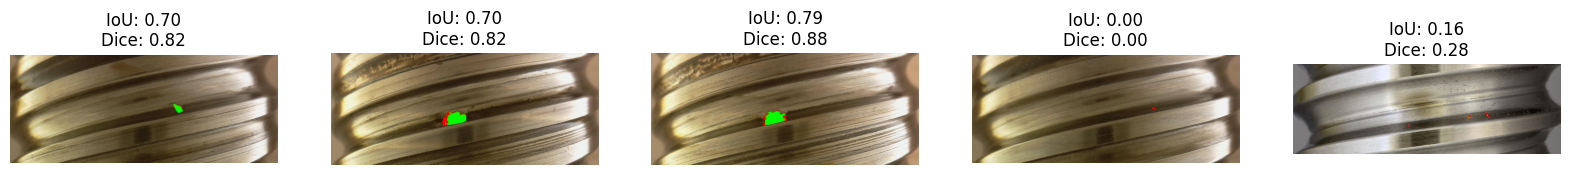

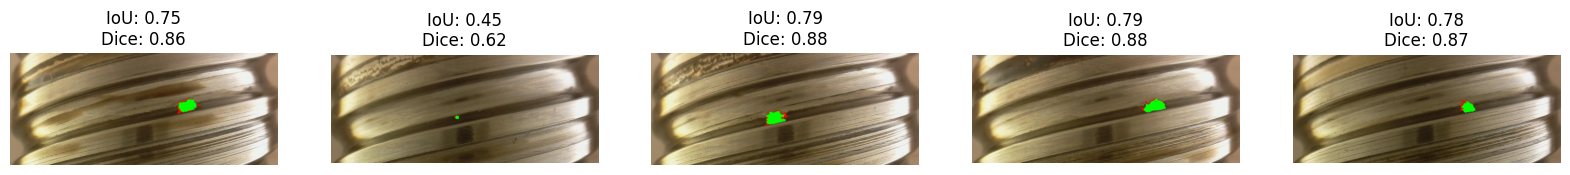

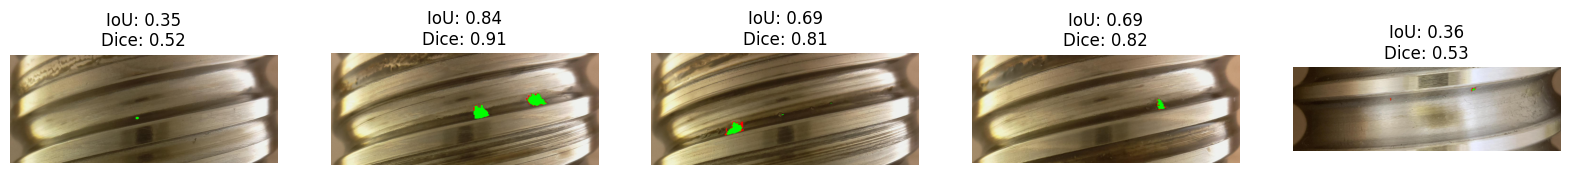

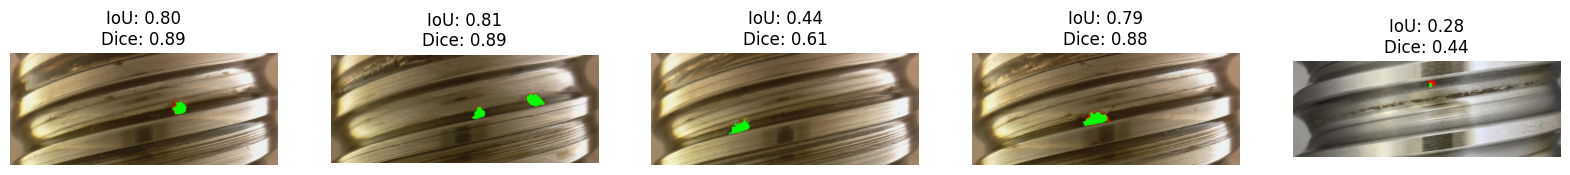

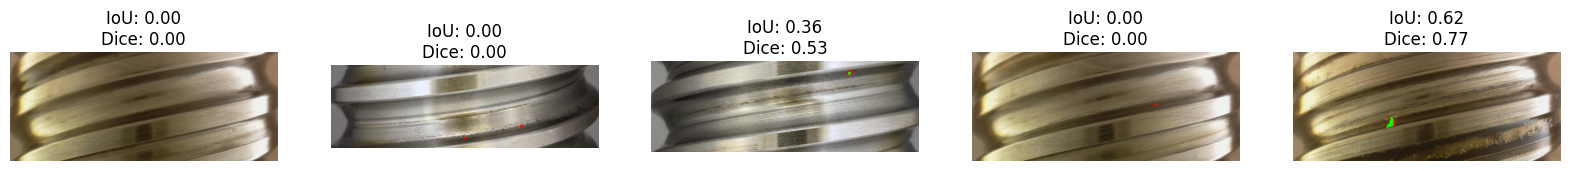

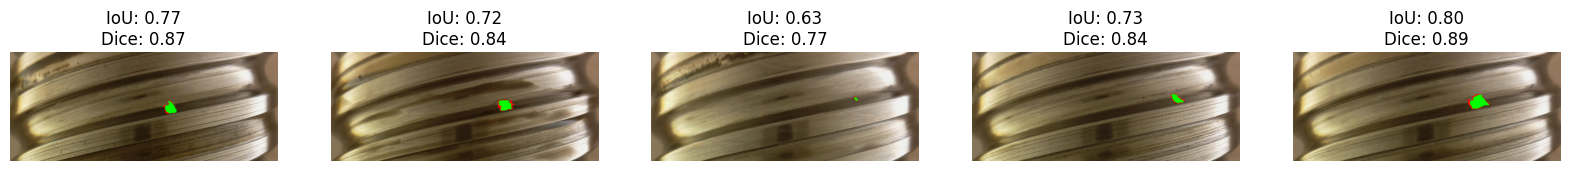

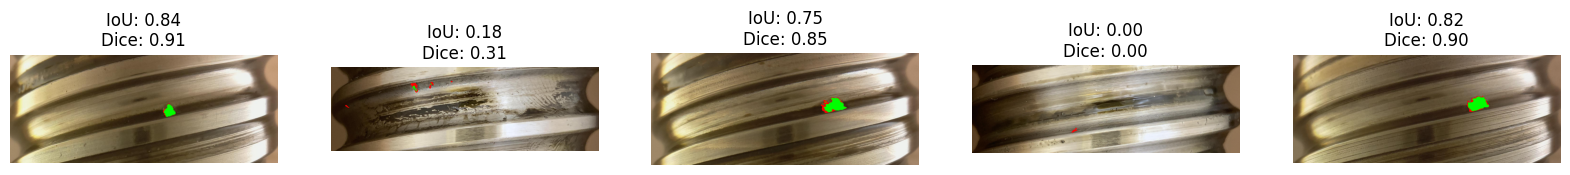

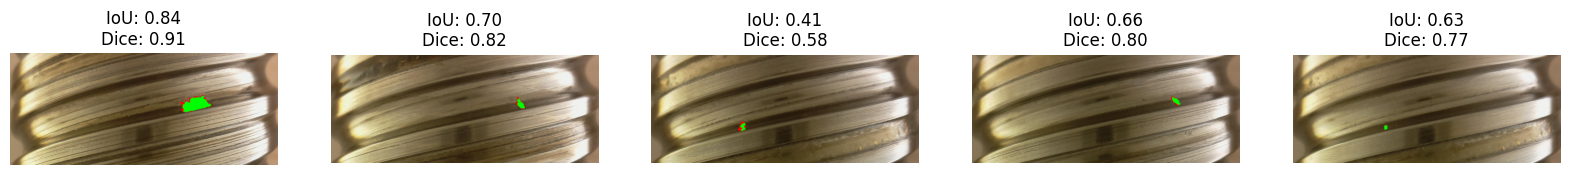

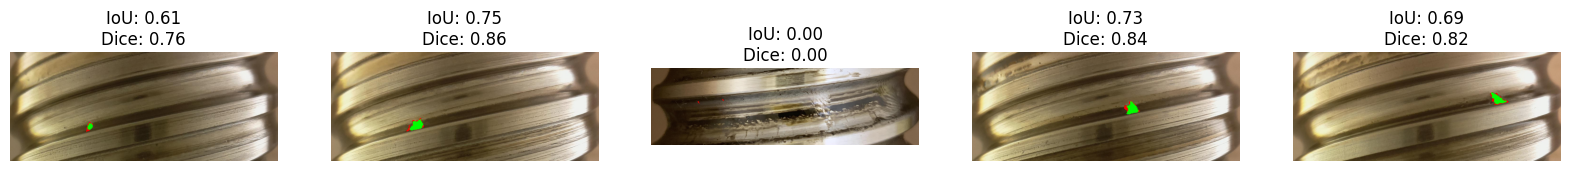

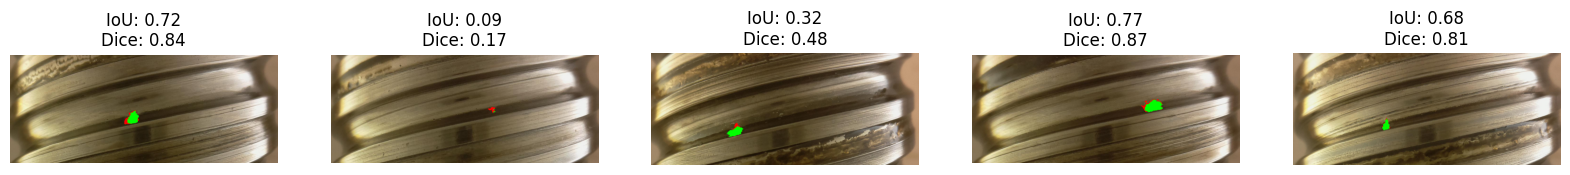

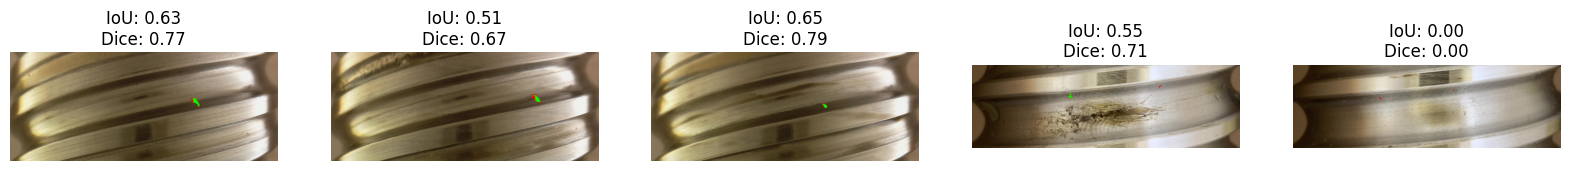

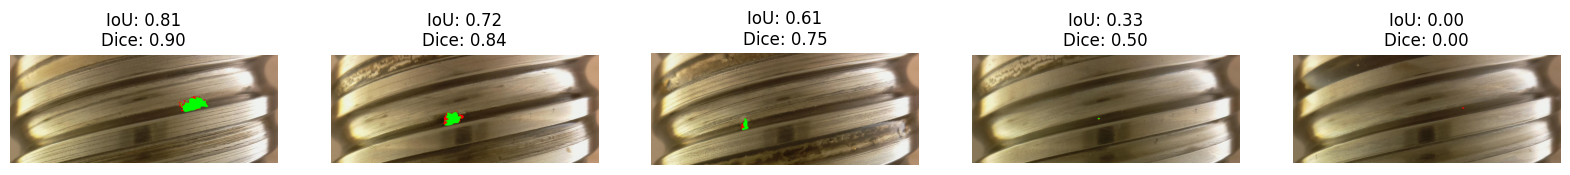

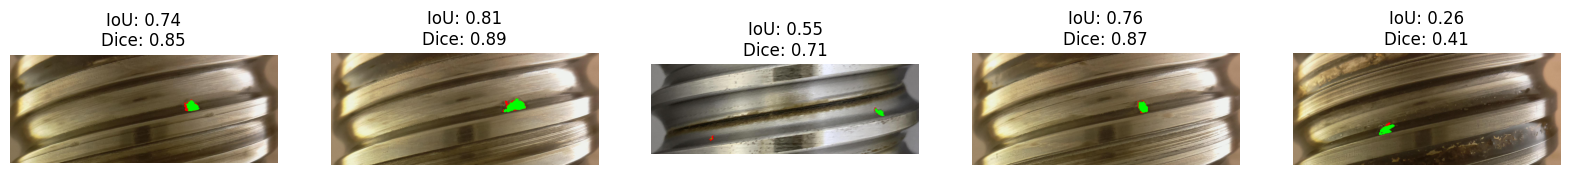

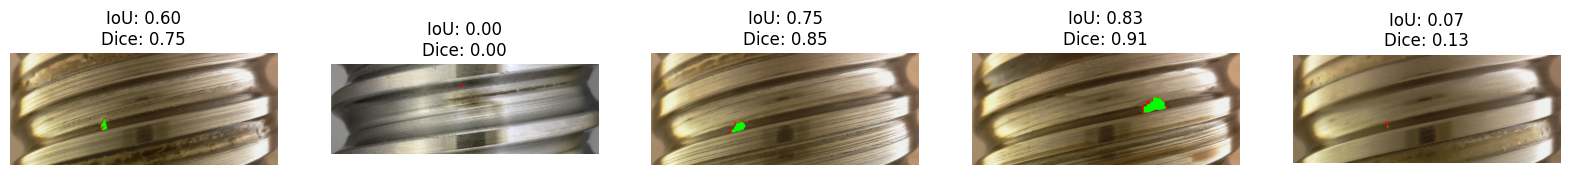

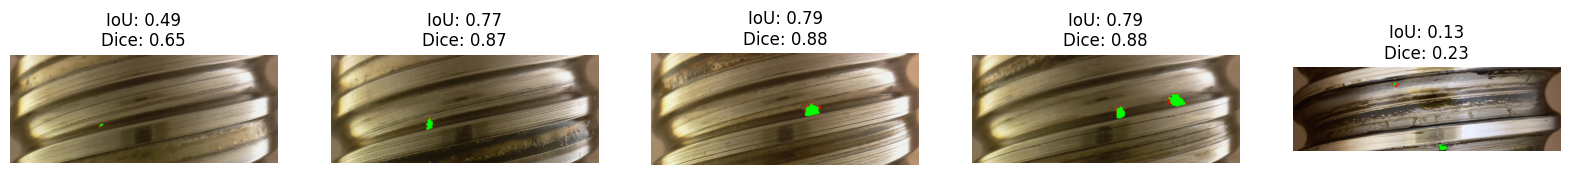

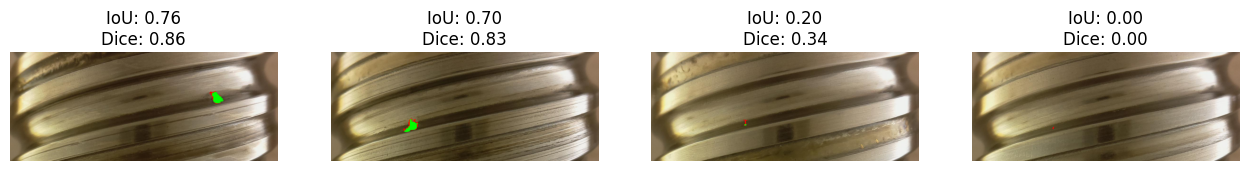

In [29]:
# モデルの評価モード
model.eval()
outputs_list = []

# val_loader からのデータに対してモデルの予測を収集
for img, mask in tqdm(val_loader):
    img = img.to(device)
    with torch.no_grad():
        outputs = model(img)
    outputs_list.extend(outputs.cpu().numpy())

iou_list = []
dice_list = []

# 5枚ごとに分割して表示
num_images = len(val_img_paths)
num_batches = (num_images + 4) // 5  # 5枚ずつ分割したときのバッチ数

for batch_idx in range(num_batches):
    start_idx = batch_idx * 5
    end_idx = min(start_idx + 5, num_images)
    plt.figure(figsize=(20, 10))
    for i in range(start_idx, end_idx):
        plt.subplot(1, 5, i - start_idx + 1)
        img = Image.open(val_img_paths[i]).convert("RGB")
        mask = val_mask_list[i]

        # imgとmaskをNumPy配列に変換
        img = np.array(img)
        mask = np.array(mask)

        # マスクされた部分を赤色にする
        img[mask == 1] = [255, 0, 0]

        # モデルからの予測結果を取得
        pred = outputs_list[i]
        pred = np.squeeze(pred)  # バッチ次元を除く
        if pred.ndim == 3:
            pred = pred[0]  # チャネル次元を除く（最初のチャネルを使用）

        # predをimgのサイズにリサイズする
        pred_resized = cv2.resize(
            pred, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST
        )

        # 予測マスクを元の画像に適用
        img[pred_resized > 0.5] = [0, 255, 0]  # 予測された部分を緑色で表示

        # IoUの計算
        mask_resized = cv2.resize(
            mask, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST
        )
        pred_resized = pred_resized > 0.5
        mask_resized = mask_resized > 0.5
        intersection = np.logical_and(pred_resized, mask_resized)
        union = np.logical_or(pred_resized, mask_resized)
        iou = np.sum(intersection) / np.sum(union)
        iou_list.append(iou)

        # Dice係数（F値）の計算
        dice = 2 * np.sum(intersection) / (np.sum(pred_resized) + np.sum(mask_resized))
        dice_list.append(dice)

        plt.imshow(img)
        plt.title(f"IoU: {iou:.2f}\nDice: {dice:.2f}")
        plt.axis("off")

    plt.show()

In [30]:
# IoUの平均値を計算
iou_mean = np.mean(iou_list)
print(f"Mean IoU: {iou_mean:.2f}")

Mean IoU: 0.54


In [31]:
# Dice係数の平均値を計算
dice_mean = np.mean(dice_list)
print(f"Mean Dice: {dice_mean:.2f}")

Mean Dice: 0.64


In [32]:
# IoU=0の水準を除いてIoUの平均値を計算
iou_mean = np.mean([iou for iou in iou_list if iou > 0])
print(f"Mean IoU (IoU=0 excluded): {iou_mean:.2f}")

Mean IoU (IoU=0 excluded): 0.62


In [33]:
# Dice=0の水準を除いてDice係数の平均値を計算
dice_mean = np.mean([dice for dice in dice_list if dice > 0])
print(f"Mean Dice (Dice=0 excluded): {dice_mean:.2f}")

Mean Dice (Dice=0 excluded): 0.74


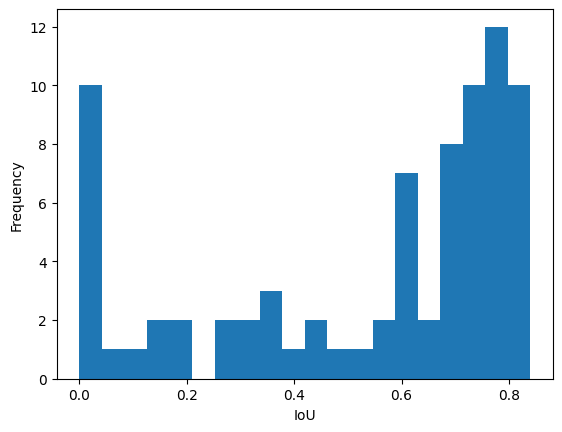

In [34]:
# IoUの分布を表示
plt.hist(iou_list, bins=20)
plt.xlabel("IoU")
plt.ylabel("Frequency")
plt.show()

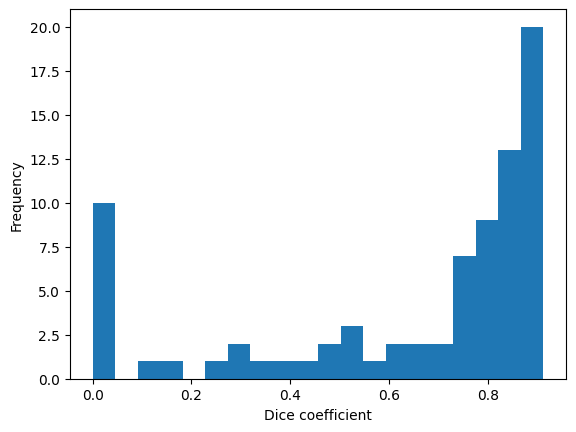

In [35]:
# Dice係数の分布を表示
plt.hist(dice_list, bins=20)
plt.xlabel("Dice coefficient")
plt.ylabel("Frequency")
plt.show()